In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from minigrid.wrappers import ImgObsWrapper
from IPython.display import display

# from models.features_extractor import C4EquivariantCNN
from sb3_ppo import make_ppo_agent
from evaluation.evaluation import capture_frames_sb3, count_parameters
from evaluation.visualization import create_animation, plot_parameter_comparison

In [9]:
# Configuration
ENV_NAME = 'MiniGrid-Empty-8x8-v0'

# Training parameters
TIMESTEPS = 1e4      # Training timesteps

# Evaluation parameters
NUM_EVAL_EPISODES = 5
RENDER_EVALUATION = True

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## 1. Setting Up the Environment

We'll use the MiniGrid environment wrapped with ImgObsWrapper to provide image observations.

In [10]:
vec_env = make_vec_env(ENV_NAME, n_envs=4, seed=SEED,
                               wrapper_class=ImgObsWrapper)

eval_env = gym.make(ENV_NAME, render_mode="rgb_array")
eval_env = ImgObsWrapper(eval_env)
eval_env = Monitor(eval_env)

print(f"Environment: {ENV_NAME}")
print(f"Observation shape: {eval_env.observation_space.shape}")
print(f"Action space: {eval_env.action_space}")

Environment: MiniGrid-Empty-8x8-v0
Observation shape: (7, 7, 3)
Action space: Discrete(7)


## 2. PPO Default Hyperparameters

Below are the default hyperparameters for PPO that can be configured:

In [11]:
# Default PPO hyperparameters that can be configured
default_ppo_params = {
    "learning_rate": 1e-3,
    "n_steps": 2048,
    "batch_size": 64,
    "n_epochs": 10,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "clip_range_vf": None,
    "normalize_advantage": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
}

# Optional: you can customize these parameters for your agents
standard_config = default_ppo_params.copy()
equivariant_config = default_ppo_params.copy()

In [12]:
print("Creating standard CNN PPO agent...")
standard_agent = make_ppo_agent(
    vec_env, 
    use_equivariant_cnn=False, 
    seed=SEED,
    config=standard_config
)

print("\nCreating C4 equivariant CNN PPO agent...")
equivariant_agent = make_ppo_agent(
    vec_env, 
    use_equivariant_cnn=True, 
    seed=SEED,
    config=equivariant_config
)

print("\nAgents created successfully!")

Creating standard CNN PPO agent...
Using cpu device
Wrapping the env in a VecTransposeImage.

Creating C4 equivariant CNN PPO agent...
Using cpu device
Wrapping the env in a VecTransposeImage.

Agents created successfully!


## 3. Training Agents

Train both the standard CNN and C4 equivariant CNN PPO agents.

In [13]:
# Train standard CNN PPO agent
print(f"Training standard CNN PPO for {TIMESTEPS} timesteps...")
standard_agent.learn(total_timesteps=int(TIMESTEPS))
print("Standard CNN training completed!")

Training standard CNN PPO for 10000.0 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 234      |
|    ep_rew_mean     | 0.0882   |
| time/              |          |
|    fps             | 1608     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 232        |
|    ep_rew_mean          | 0.101      |
| time/                   |            |
|    fps                  | 569        |
|    iterations           | 2          |
|    time_elapsed         | 28         |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.00816723 |
|    clip_fraction        | 0.0483     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | -0.0107

In [14]:
# Train C4 equivariant CNN PPO agent
print(f"Training C4 equivariant CNN PPO for {TIMESTEPS} timesteps...")
equivariant_agent.learn(total_timesteps=int(TIMESTEPS))
print("Equivariant CNN training completed!")

Training C4 equivariant CNN PPO for 10000.0 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 233      |
|    ep_rew_mean     | 0.101    |
| time/              |          |
|    fps             | 1597     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 236         |
|    ep_rew_mean          | 0.0913      |
| time/                   |             |
|    fps                  | 404         |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009678582 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_

In [15]:
# Evaluate standard CNN agent
print("\n=== Standard CNN PPO Evaluation ===")
std_mean_reward, std_std_reward = evaluate_policy(standard_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES)
print(f"Mean reward: {std_mean_reward:.2f} +/- {std_std_reward:.2f}")

# Evaluate equivariant CNN agent
print("\n=== C4 Equivariant CNN PPO Evaluation ===")
eq_mean_reward, eq_std_reward = evaluate_policy(equivariant_agent, eval_env, n_eval_episodes=NUM_EVAL_EPISODES)
print(f"Mean reward: {eq_mean_reward:.2f} +/- {eq_std_reward:.2f}")

# Compare performance
print("\n=== Performance Comparison ===")
improvement = (eq_mean_reward - std_mean_reward) / abs(std_mean_reward) * 100 if std_mean_reward != 0 else float('inf')
print(f"Improvement with C4 equivariance: {improvement:.2f}%")


=== Standard CNN PPO Evaluation ===
Mean reward: 0.00 +/- 0.00

=== C4 Equivariant CNN PPO Evaluation ===
Mean reward: 0.00 +/- 0.00

=== Performance Comparison ===
Improvement with C4 equivariance: inf%


## Visualizing Custom PPO Agent

Standard CNN PPO Agent Trajectory:



C4 Equivariant CNN PPO Agent Trajectory:


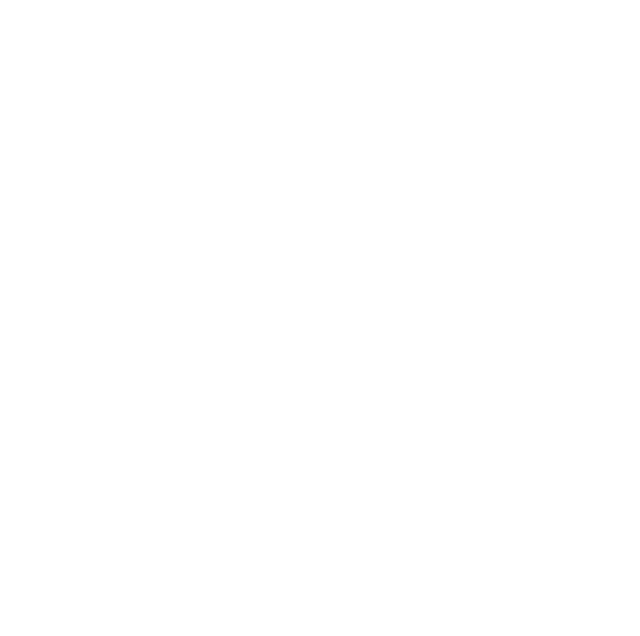

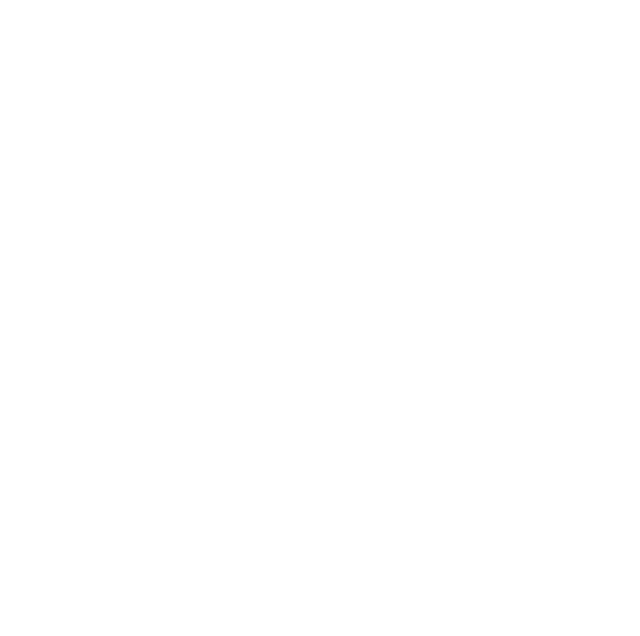

In [16]:
# Visualize standard CNN agent behavior
print("Standard CNN PPO Agent Trajectory:")
std_frames = capture_frames_sb3(standard_agent, eval_env)
display(create_animation(std_frames))

# Visualize equivariant CNN agent behavior
print("\nC4 Equivariant CNN PPO Agent Trajectory:")
eq_frames = capture_frames_sb3(equivariant_agent, eval_env)
display(create_animation(eq_frames))

In [ ]:
# Print model architectures
print("Standard CNN PPO Architecture:")
print(standard_agent.policy)
print("\nC4 Equivariant CNN PPO Architecture:")
print(equivariant_agent.policy)

# Compare parameter counts
std_params = count_parameters(standard_agent.policy)
eq_params = count_parameters(equivariant_agent.policy)

print(f"\nParameter Count Comparison:")
print(f"Standard CNN PPO: {std_params:,} parameters")
print(f"C4 Equivariant CNN PPO: {eq_params:,} parameters")

# Plot parameter comparison
labels = ['Standard CNN', 'C4 Equivariant CNN']
values = [std_params, eq_params]
plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.title('Parameter Count Comparison')
plt.ylabel('Number of Parameters')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:,}", ha='center')
plt.show()

## 7. Sample Efficiency Analysis

We can analyze the sample efficiency of both approaches by plotting learning curves.

In [ ]:
# Plot learning curves from training
def plot_learning_curves(standard_agent, equivariant_agent):
    '''Plot learning curves from the agent training'''
    plt.figure(figsize=(12, 8))
    
    # Extract data
    std_data = standard_agent.ep_info_buffer
    eq_data = equivariant_agent.ep_info_buffer
    
    if len(std_data) > 0 and len(eq_data) > 0:
        # Extract rewards and lengths
        std_rewards = [ep['r'] for ep in std_data]
        eq_rewards = [ep['r'] for ep in eq_data]
        
        std_lengths = [ep['l'] for ep in std_data]
        eq_lengths = [ep['l'] for ep in eq_data]
        
        # Plot rewards
        plt.subplot(2, 1, 1)
        plt.plot(std_rewards, label='Standard CNN')
        plt.plot(eq_rewards, label='C4 Equivariant CNN')
        plt.title('Episode Rewards during Training')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot episode lengths
        plt.subplot(2, 1, 2)
        plt.plot(std_lengths, label='Standard CNN')
        plt.plot(eq_lengths, label='C4 Equivariant CNN')
        plt.title('Episode Lengths during Training')
        plt.xlabel('Episode')
        plt.ylabel('Length')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No training data available in the info buffer.")

plot_learning_curves(standard_agent, equivariant_agent)

In [ ]:
import gym
import minigrid
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from models.features_extractor import C4EquivariantCNN, EquivariantActorCriticPolicy

# Create the environment
env_id = "MiniGrid-Empty-8x8-v0"
env = gym.make(env_id)

# Initialize the PPO model with our custom policy
model = PPO(
    EquivariantActorCriticPolicy,
    env,
    verbose=1,
)

# Train the model
model.learn(total_timesteps=10000)  # Use a smaller value for demonstration

# Test the trained model
obs = env.reset()
done = False
steps = 0
total_reward = 0

# Visualize an episode
plt.figure(figsize=(10, 10))

while not done and steps < 100:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    steps += 1
    
    # Display every 5th frame
    if steps % 5 == 0:
        plt.subplot(4, 5, steps//5)
        plt.imshow(env.render(mode='rgb_array'))
        plt.axis('off')
        plt.title(f'Step {steps}')

plt.tight_layout()
plt.savefig('minigrid_episode.png')
plt.show()

print(f"Episode completed in {steps} steps with reward {total_reward}")

# Show the architecture of our feature extractor
print("C4EquivariantCNN Architecture:")
obs_shape = env.observation_space.shape
features_extractor = C4EquivariantCNN(env.observation_space)
print(features_extractor)

# Demonstrate equivariance by rotating an input
sample_obs = env.reset()
# Create rotated versions of the observation
# This is just a demonstration - in practice, you'd need proper rotation logic
rotated_obs = np.transpose(sample_obs, (0, 2, 1))  # Simple 90-degree rotation for demo

# Process both with the feature extractor
with torch.no_grad():
    sample_tensor = torch.tensor(sample_obs).unsqueeze(0).float()
    rotated_tensor = torch.tensor(rotated_obs).unsqueeze(0).float()
    
    features_original = model.policy.features_extractor(sample_tensor)
    features_rotated = model.policy.features_extractor(rotated_tensor)
    
    print(f"Original features shape: {features_original.shape}")
    print(f"Rotated features shape: {features_rotated.shape}")